<a href="https://colab.research.google.com/github/aguilarafa2010/Aplicacao_Multimidia/blob/main/Atividade_4_Classificacao_Doenca_Pulmonar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Bibliotecas

# Load the images from the dataset (1000 images, 10 different classes)
from imutils import paths
from google.colab.patches import cv2_imshow
import os, cv2

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
import itertools

import numpy as np
import pandas as pd

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn import metrics
from sklearn.cluster import KMeans

from skimage import io, util
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.morphology import label

import pickle

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import matplotlib.style as sty
import seaborn as sns

plt.rcParams["figure.figsize"] = [20,5]
sns.set_style("ticks")

# Funções Gerais


In [3]:
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [4]:
#Função para realizar e plotar a matrix de confusão 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation = 'nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)
  
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")
   
  thresh = cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j, i, cm[i,j], horizontalalignment="center", color="white" if cm[i,j]>thresh else "black")
   
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [5]:
def stats(y_test, preds):
  acc = metrics.accuracy_score(y_test, preds)
  print('Accuracy:', f'{acc:.4f}')

  prec_micro = metrics.precision_score(y_test, preds, average='micro')
  print('Precision (Micro):', f'{prec_micro:.4f}')

  prec_macro = metrics.precision_score(y_test, preds, average='macro')
  print('Precision (Macro):', f'{prec_macro:.4f}')

  rec_micro = metrics.recall_score(y_test, preds, average='micro')
  print('Recall (Micro):', f'{rec_micro:.4f}')

  rec_macro = metrics.recall_score(y_test, preds, average='macro')
  print('Recall (Macro):', f'{rec_macro:.4f}')

  f1_micro = metrics.f1_score(y_test, preds, average='micro')
  print('F1 (Micro):', f'{f1_micro:.4f}')

  f1_macro = metrics.f1_score(y_test, preds, average='macro')
  print('F1 (Macro):', f'{f1_macro:.4f}')

## Salvamento e teste do modelo

In [6]:
# Saving  model
def save_model(model, model_name):
  pickle.dump(model, open(f'{model_name}_model', 'wb'))

In [7]:
## Imagens para testes dos métodos
path = '/content/feature_matrix_desafio-covid-multimedia.csv'
imagens = pd.DataFrame(pd.read_csv(path))

IMAGENS_TESTE = []

for index, row in  imagens.iterrows():
  x = []
  for i in row:
    x.append(i)
  IMAGENS_TESTE.append(x)

def model_teste(model_name):
  # load the model from disk
  loaded_model = pickle.load(open(f'{model_name}', 'rb'))

  print(f'-------------------------------------------------------------------- {model_name}')

  for i in IMAGENS_TESTE:
    result = loaded_model.predict([IMAGENS_TESTE[1]])
    print(f'Classe da imagem teste - {result[0]}')

## Etapa de Treinamento,  Teste e Avaliação dos Resultados

In [8]:
def conf_matrix(y_test, preds, title, times):
  cm = confusion_matrix(y_test, preds)
  cm_plot_labels = classes
  plot_confusion_matrix(cm, cm_plot_labels, title = f'Confusion Matrix --- {title}_{times}')
  plt.show()

In [9]:
def model_train(model, model_name, train_X, train_y, test_X, y_test, times):
  model.fit(train_X, train_y)

  preds =  model.predict(test_X)

  conf_matrix(y_test, preds, model_name, times)

  stats(y_test, preds)
  
  save_model(model, f'{model_name}_{times}')

In [10]:
## SMOTE - Tomek Link

def smote_tomek(model, model_name, X_train, X_test, y_train, y_test, classes):
  
  k = list(range(1,len(classes)))

  tl = TomekLinks(sampling_strategy='auto')

  for i in k:
    sm = SMOTE(sampling_strategy='auto', random_state=15, k_neighbors=i)

    print(f'-------------------------------------------------------------------- {model_name}_{i}')
    ## SMOTE
    print(f'----------------------------- SMOTE_{model_name}_{i}')
    X_smote, y_smote = sm.fit_resample(X_train,y_train)

    train_X, test_X = prep_pixels(X_smote, X_test)
    train_y = y_smote
    
    model_train(model, model_name + '_SMOTE', train_X, train_y, test_X, y_test, i)
    
    ## Tomek Link
    print(f'----------------------------- Tomek_Link_{model_name}_{i}')
    X_tomek, y_tomek = tl.fit_resample(X_smote, y_smote)

    train_X, test_X = prep_pixels(X_tomek, X_test)
    train_y = y_tomek

    model_train(model, model_name + '_Tomek', train_X, train_y, test_X, y_test, i)   

In [11]:
classes = ['Normal', 'COVID-19', 'Streptococcus', 'SARS', 'Varicella',  'Pneumocystis', 'MERS']

#Carregar os arquivos de treinamento e teste:
train_data = pd.read_csv('pneumonia_lbp.train.arff.csv')
test_data = pd.read_csv('pneumonia_lbp.test.arff.csv')

X_train = train_data.drop('class', axis=1).values
y_train = train_data['class'].values

X_test = test_data.drop('class', axis=1).values
y_test = test_data['class'].values

## Modelos de Classificação

-------------------------------------------------------------------- KNN_1
----------------------------- SMOTE_KNN_1
Confusion matrix, without normalization


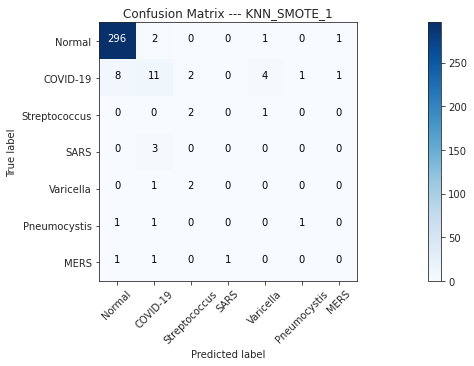

Accuracy: 0.9064
Precision (Micro): 0.9064
Precision (Macro): 0.3399
Recall (Micro): 0.9064
Recall (Macro): 0.3420
F1 (Micro): 0.9064
F1 (Macro): 0.3285
----------------------------- Tomek_Link_KNN_1
Confusion matrix, without normalization


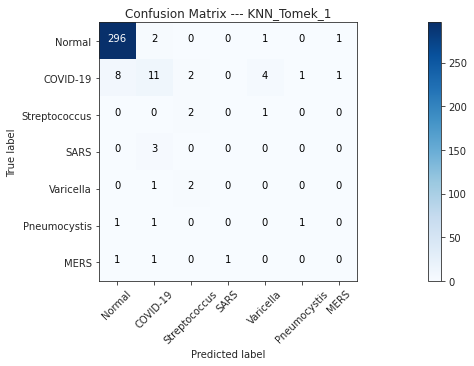

Accuracy: 0.9064
Precision (Micro): 0.9064
Precision (Macro): 0.3399
Recall (Micro): 0.9064
Recall (Macro): 0.3420
F1 (Micro): 0.9064
F1 (Macro): 0.3285
-------------------------------------------------------------------- KNN_2
----------------------------- SMOTE_KNN_2
Confusion matrix, without normalization


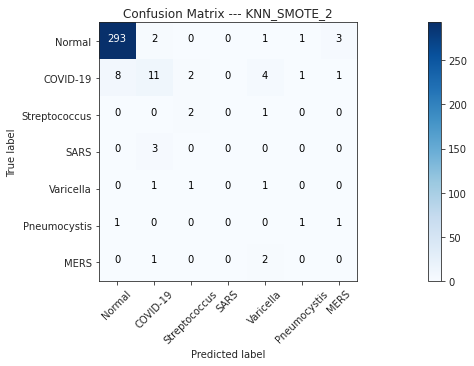

Accuracy: 0.9006
Precision (Micro): 0.9006
Precision (Macro): 0.3465
Recall (Micro): 0.9006
Recall (Macro): 0.3882
F1 (Micro): 0.9006
F1 (Macro): 0.3518
----------------------------- Tomek_Link_KNN_2
Confusion matrix, without normalization


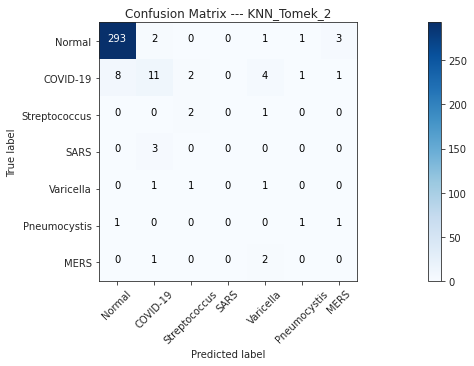

Accuracy: 0.9006
Precision (Micro): 0.9006
Precision (Macro): 0.3465
Recall (Micro): 0.9006
Recall (Macro): 0.3882
F1 (Micro): 0.9006
F1 (Macro): 0.3518
-------------------------------------------------------------------- KNN_3
----------------------------- SMOTE_KNN_3
Confusion matrix, without normalization


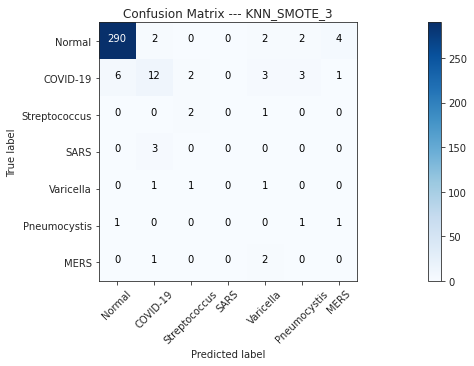

Accuracy: 0.8947
Precision (Micro): 0.8947
Precision (Macro): 0.3265
Recall (Micro): 0.8947
Recall (Macro): 0.3921
F1 (Micro): 0.8947
F1 (Macro): 0.3403
----------------------------- Tomek_Link_KNN_3
Confusion matrix, without normalization


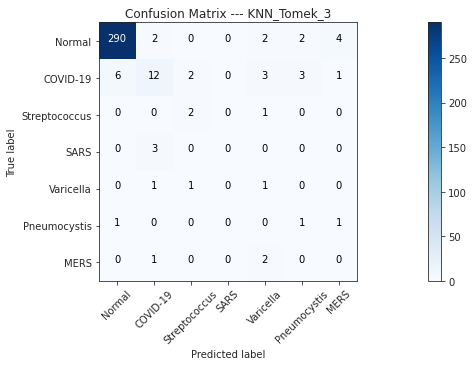

Accuracy: 0.8947
Precision (Micro): 0.8947
Precision (Macro): 0.3265
Recall (Micro): 0.8947
Recall (Macro): 0.3921
F1 (Micro): 0.8947
F1 (Macro): 0.3403
-------------------------------------------------------------------- KNN_4
----------------------------- SMOTE_KNN_4
Confusion matrix, without normalization


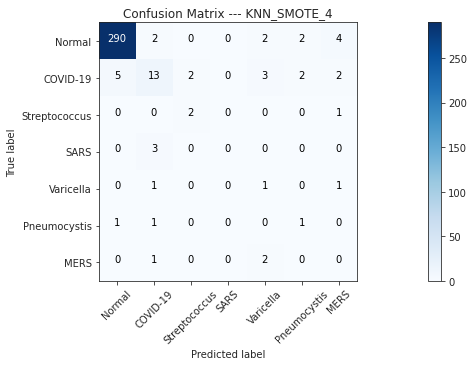

Accuracy: 0.8977
Precision (Micro): 0.8977
Precision (Macro): 0.3463
Recall (Micro): 0.8977
Recall (Macro): 0.3974
F1 (Micro): 0.8977
F1 (Macro): 0.3597
----------------------------- Tomek_Link_KNN_4
Confusion matrix, without normalization


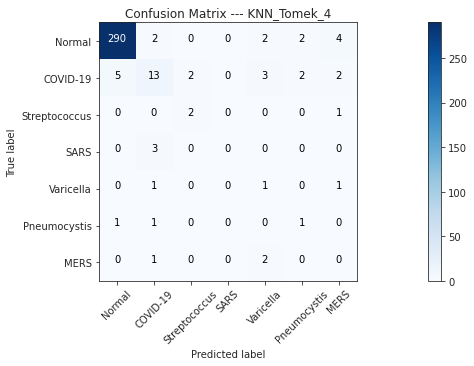

Accuracy: 0.8977
Precision (Micro): 0.8977
Precision (Macro): 0.3463
Recall (Micro): 0.8977
Recall (Macro): 0.3974
F1 (Micro): 0.8977
F1 (Macro): 0.3597
-------------------------------------------------------------------- KNN_5
----------------------------- SMOTE_KNN_5
Confusion matrix, without normalization


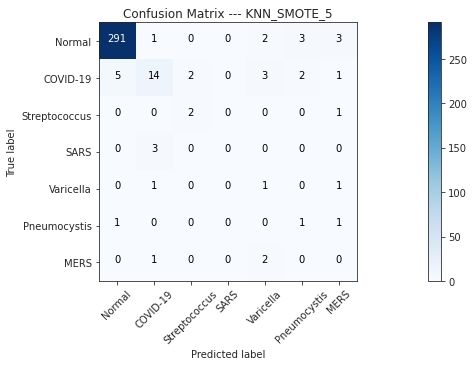

Accuracy: 0.9035
Precision (Micro): 0.9035
Precision (Macro): 0.3531
Recall (Micro): 0.9035
Recall (Macro): 0.4031
F1 (Micro): 0.9035
F1 (Macro): 0.3637
----------------------------- Tomek_Link_KNN_5
Confusion matrix, without normalization


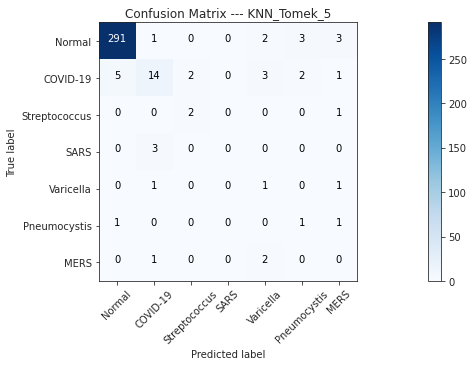

Accuracy: 0.9035
Precision (Micro): 0.9035
Precision (Macro): 0.3531
Recall (Micro): 0.9035
Recall (Macro): 0.4031
F1 (Micro): 0.9035
F1 (Macro): 0.3637
-------------------------------------------------------------------- KNN_6
----------------------------- SMOTE_KNN_6
Confusion matrix, without normalization


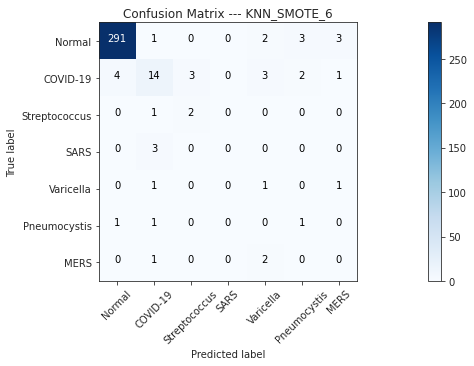

Accuracy: 0.9035
Precision (Micro): 0.9035
Precision (Macro): 0.3302
Recall (Micro): 0.9035
Recall (Macro): 0.4031
F1 (Micro): 0.9035
F1 (Macro): 0.3503
----------------------------- Tomek_Link_KNN_6
Confusion matrix, without normalization


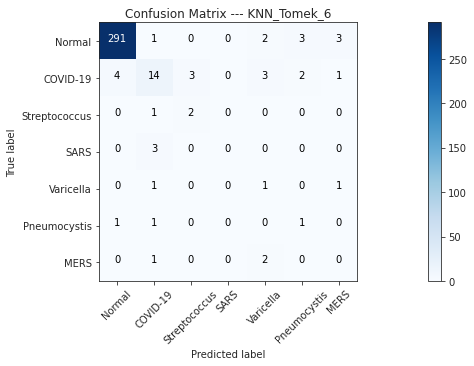

Accuracy: 0.9035
Precision (Micro): 0.9035
Precision (Macro): 0.3302
Recall (Micro): 0.9035
Recall (Macro): 0.4031
F1 (Micro): 0.9035
F1 (Macro): 0.3503


In [12]:
## Modelo KNN
n=4
knn = KNeighborsClassifier(n_neighbors=n, metric= 'euclidean')

smote_tomek(knn, 'KNN', X_train, X_test, y_train, y_test, classes)

-------------------------------------------------------------------- SVM_1
----------------------------- SMOTE_SVM_1
Confusion matrix, without normalization


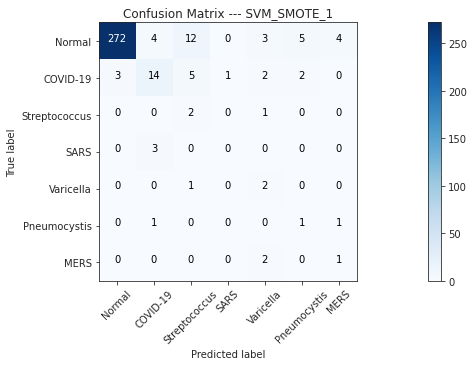

Accuracy: 0.8538
Precision (Micro): 0.8538
Precision (Macro): 0.3167
Recall (Micro): 0.8538
Recall (Macro): 0.4893
F1 (Micro): 0.8538
F1 (Macro): 0.3433
----------------------------- Tomek_Link_SVM_1
Confusion matrix, without normalization


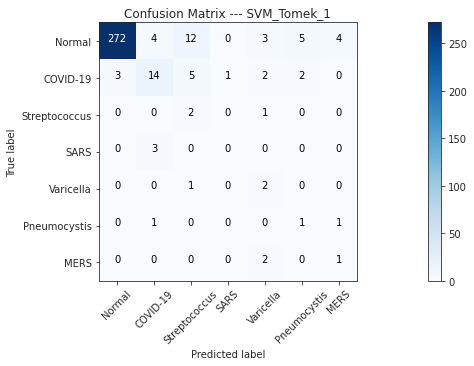

Accuracy: 0.8538
Precision (Micro): 0.8538
Precision (Macro): 0.3167
Recall (Micro): 0.8538
Recall (Macro): 0.4893
F1 (Micro): 0.8538
F1 (Macro): 0.3433
-------------------------------------------------------------------- SVM_2
----------------------------- SMOTE_SVM_2
Confusion matrix, without normalization


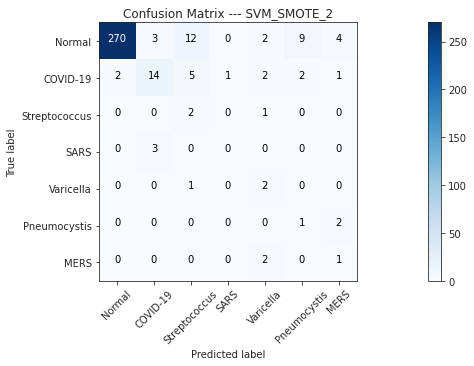

Accuracy: 0.8480
Precision (Micro): 0.8480
Precision (Macro): 0.3176
Recall (Micro): 0.8480
Recall (Macro): 0.4884
F1 (Micro): 0.8480
F1 (Macro): 0.3375
----------------------------- Tomek_Link_SVM_2
Confusion matrix, without normalization


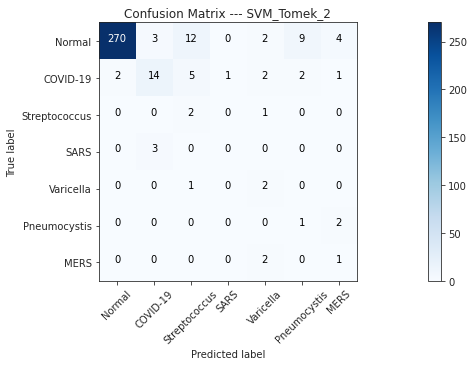

Accuracy: 0.8480
Precision (Micro): 0.8480
Precision (Macro): 0.3176
Recall (Micro): 0.8480
Recall (Macro): 0.4884
F1 (Micro): 0.8480
F1 (Macro): 0.3375
-------------------------------------------------------------------- SVM_3
----------------------------- SMOTE_SVM_3
Confusion matrix, without normalization


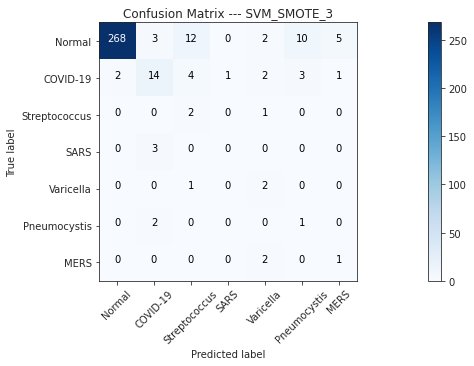

Accuracy: 0.8421
Precision (Micro): 0.8421
Precision (Macro): 0.3101
Recall (Micro): 0.8421
Recall (Macro): 0.4874
F1 (Micro): 0.8421
F1 (Macro): 0.3349
----------------------------- Tomek_Link_SVM_3
Confusion matrix, without normalization


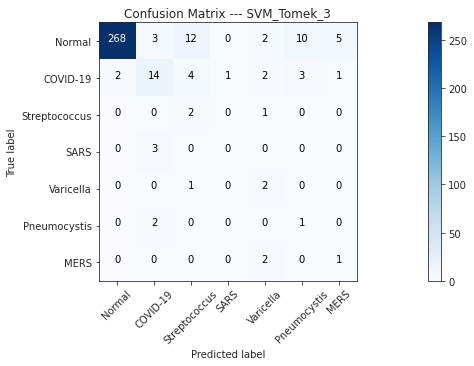

Accuracy: 0.8421
Precision (Micro): 0.8421
Precision (Macro): 0.3101
Recall (Micro): 0.8421
Recall (Macro): 0.4874
F1 (Micro): 0.8421
F1 (Macro): 0.3349
-------------------------------------------------------------------- SVM_4
----------------------------- SMOTE_SVM_4
Confusion matrix, without normalization


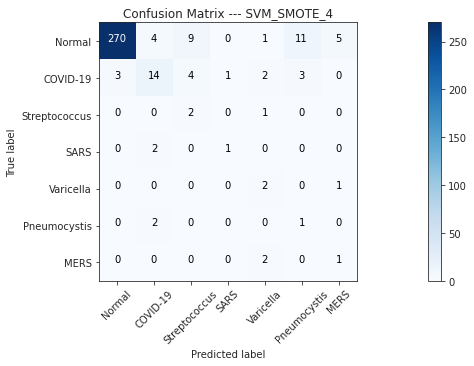

Accuracy: 0.8509
Precision (Micro): 0.8509
Precision (Macro): 0.3883
Recall (Micro): 0.8509
Recall (Macro): 0.5360
F1 (Micro): 0.8509
F1 (Macro): 0.4015
----------------------------- Tomek_Link_SVM_4
Confusion matrix, without normalization


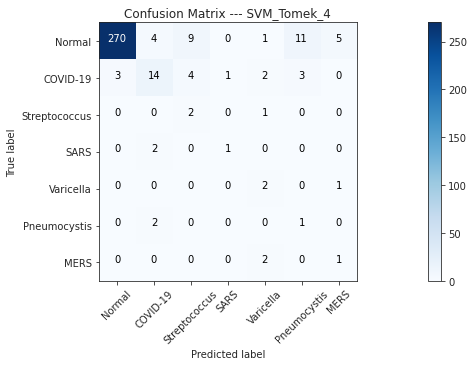

Accuracy: 0.8509
Precision (Micro): 0.8509
Precision (Macro): 0.3883
Recall (Micro): 0.8509
Recall (Macro): 0.5360
F1 (Micro): 0.8509
F1 (Macro): 0.4015
-------------------------------------------------------------------- SVM_5
----------------------------- SMOTE_SVM_5
Confusion matrix, without normalization


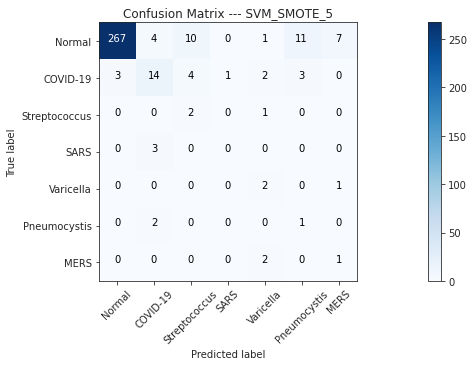

Accuracy: 0.8392
Precision (Micro): 0.8392
Precision (Macro): 0.3072
Recall (Micro): 0.8392
Recall (Macro): 0.4869
F1 (Micro): 0.8392
F1 (Macro): 0.3355
----------------------------- Tomek_Link_SVM_5
Confusion matrix, without normalization


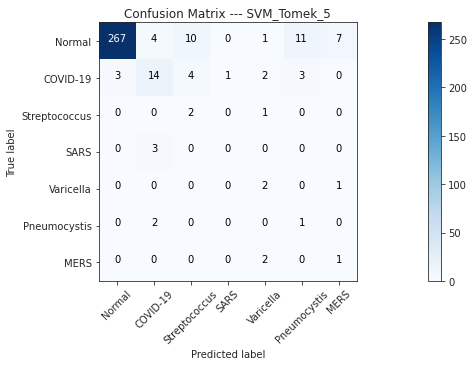

Accuracy: 0.8392
Precision (Micro): 0.8392
Precision (Macro): 0.3072
Recall (Micro): 0.8392
Recall (Macro): 0.4869
F1 (Micro): 0.8392
F1 (Macro): 0.3355
-------------------------------------------------------------------- SVM_6
----------------------------- SMOTE_SVM_6
Confusion matrix, without normalization


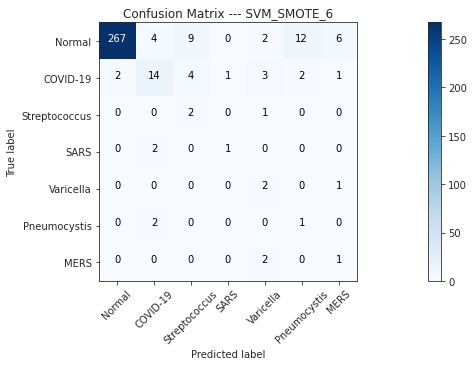

Accuracy: 0.8421
Precision (Micro): 0.8421
Precision (Macro): 0.3771
Recall (Micro): 0.8421
Recall (Macro): 0.5346
F1 (Micro): 0.8421
F1 (Macro): 0.3882
----------------------------- Tomek_Link_SVM_6
Confusion matrix, without normalization


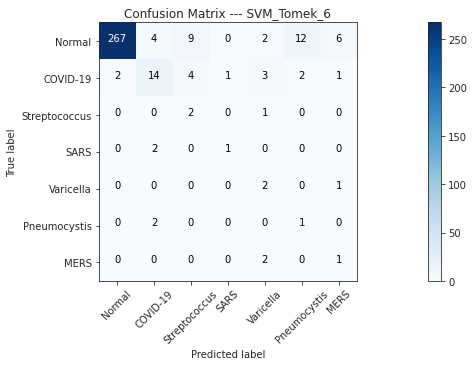

Accuracy: 0.8421
Precision (Micro): 0.8421
Precision (Macro): 0.3771
Recall (Micro): 0.8421
Recall (Macro): 0.5346
F1 (Micro): 0.8421
F1 (Macro): 0.3882


In [13]:
## Modelo SVM
svmach = svm.SVC(kernel='rbf', class_weight='balanced')

smote_tomek(svmach, 'SVM', X_train, X_test, y_train, y_test, classes)

-------------------------------------------------------------------- Logistic_Regression_1
----------------------------- SMOTE_Logistic_Regression_1
Confusion matrix, without normalization


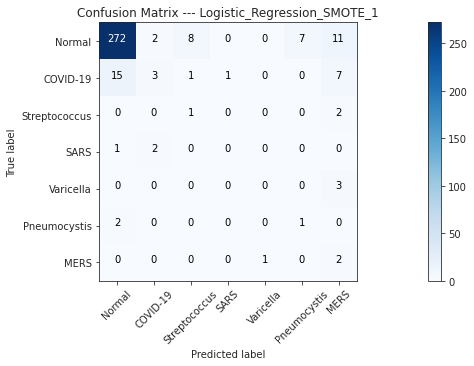

Accuracy: 0.8158
Precision (Micro): 0.8158
Precision (Macro): 0.2388
Recall (Micro): 0.8158
Recall (Macro): 0.3359
F1 (Micro): 0.8158
F1 (Macro): 0.2253
----------------------------- Tomek_Link_Logistic_Regression_1
Confusion matrix, without normalization


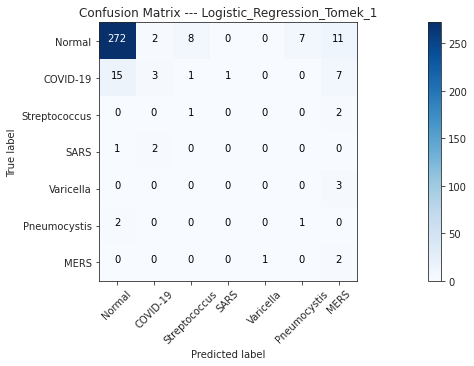

Accuracy: 0.8158
Precision (Micro): 0.8158
Precision (Macro): 0.2388
Recall (Micro): 0.8158
Recall (Macro): 0.3359
F1 (Micro): 0.8158
F1 (Macro): 0.2253
-------------------------------------------------------------------- Logistic_Regression_2
----------------------------- SMOTE_Logistic_Regression_2
Confusion matrix, without normalization


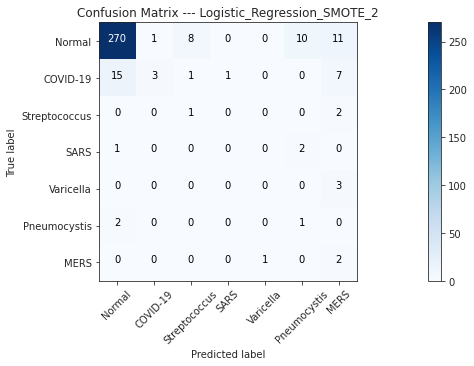

Accuracy: 0.8099
Precision (Micro): 0.8099
Precision (Macro): 0.2778
Recall (Micro): 0.8099
Recall (Macro): 0.3349
F1 (Micro): 0.8099
F1 (Macro): 0.2191
----------------------------- Tomek_Link_Logistic_Regression_2
Confusion matrix, without normalization


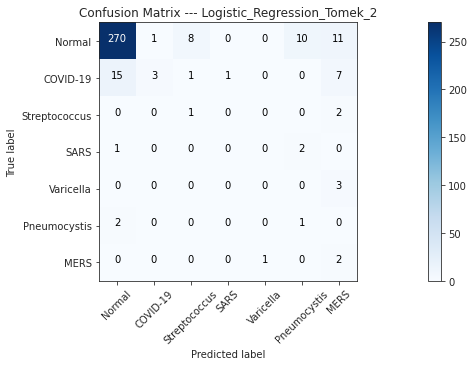

Accuracy: 0.8099
Precision (Micro): 0.8099
Precision (Macro): 0.2778
Recall (Micro): 0.8099
Recall (Macro): 0.3349
F1 (Micro): 0.8099
F1 (Macro): 0.2191
-------------------------------------------------------------------- Logistic_Regression_3
----------------------------- SMOTE_Logistic_Regression_3
Confusion matrix, without normalization


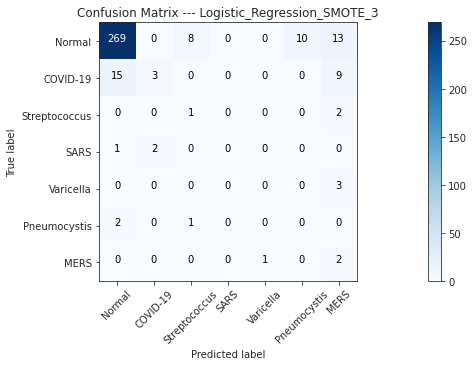

Accuracy: 0.8041
Precision (Micro): 0.8041
Precision (Macro): 0.2437
Recall (Micro): 0.8041
Recall (Macro): 0.2868
F1 (Micro): 0.8041
F1 (Macro): 0.1976
----------------------------- Tomek_Link_Logistic_Regression_3
Confusion matrix, without normalization


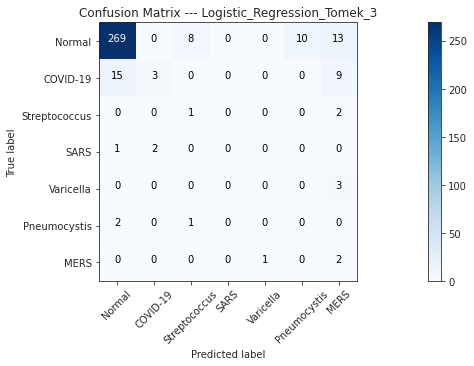

Accuracy: 0.8041
Precision (Micro): 0.8041
Precision (Macro): 0.2437
Recall (Micro): 0.8041
Recall (Macro): 0.2868
F1 (Micro): 0.8041
F1 (Macro): 0.1976
-------------------------------------------------------------------- Logistic_Regression_4
----------------------------- SMOTE_Logistic_Regression_4
Confusion matrix, without normalization


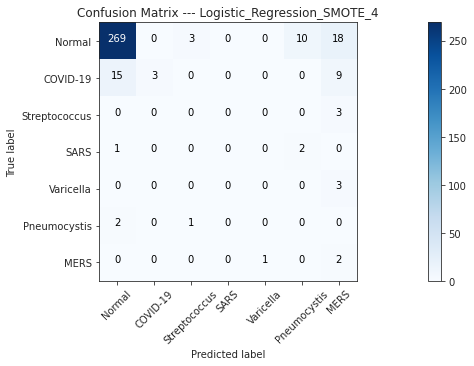

Accuracy: 0.8012
Precision (Micro): 0.8012
Precision (Macro): 0.2849
Recall (Micro): 0.8012
Recall (Macro): 0.2392
F1 (Micro): 0.8012
F1 (Macro): 0.1745
----------------------------- Tomek_Link_Logistic_Regression_4
Confusion matrix, without normalization


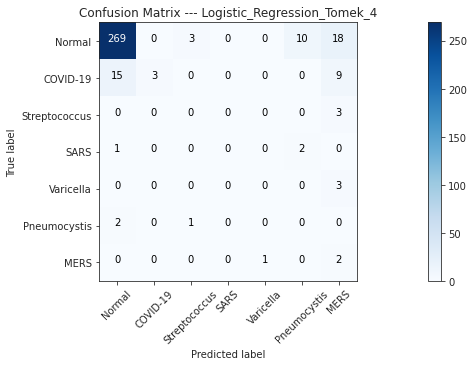

Accuracy: 0.8012
Precision (Micro): 0.8012
Precision (Macro): 0.2849
Recall (Micro): 0.8012
Recall (Macro): 0.2392
F1 (Micro): 0.8012
F1 (Macro): 0.1745
-------------------------------------------------------------------- Logistic_Regression_5
----------------------------- SMOTE_Logistic_Regression_5
Confusion matrix, without normalization


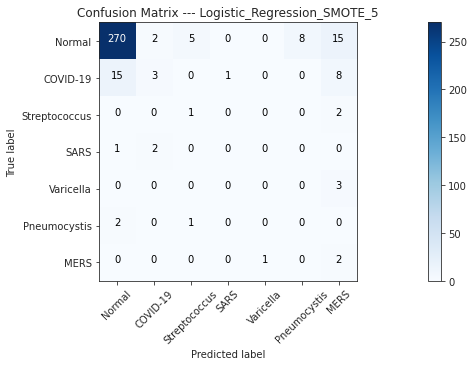

Accuracy: 0.8070
Precision (Micro): 0.8070
Precision (Macro): 0.2251
Recall (Micro): 0.8070
Recall (Macro): 0.2873
F1 (Micro): 0.8070
F1 (Macro): 0.2023
----------------------------- Tomek_Link_Logistic_Regression_5
Confusion matrix, without normalization


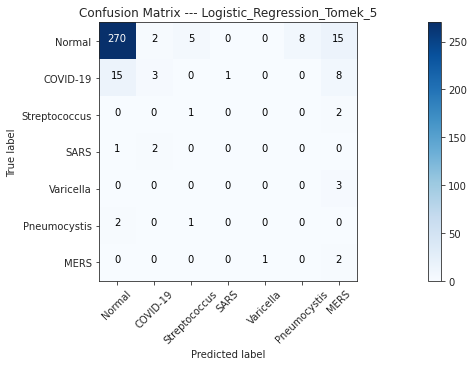

Accuracy: 0.8070
Precision (Micro): 0.8070
Precision (Macro): 0.2251
Recall (Micro): 0.8070
Recall (Macro): 0.2873
F1 (Micro): 0.8070
F1 (Macro): 0.2023
-------------------------------------------------------------------- Logistic_Regression_6
----------------------------- SMOTE_Logistic_Regression_6
Confusion matrix, without normalization


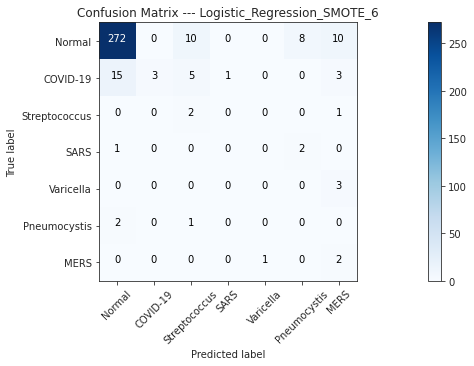

Accuracy: 0.8158
Precision (Micro): 0.8158
Precision (Macro): 0.3078
Recall (Micro): 0.8158
Recall (Macro): 0.3359
F1 (Micro): 0.8158
F1 (Macro): 0.2135
----------------------------- Tomek_Link_Logistic_Regression_6
Confusion matrix, without normalization


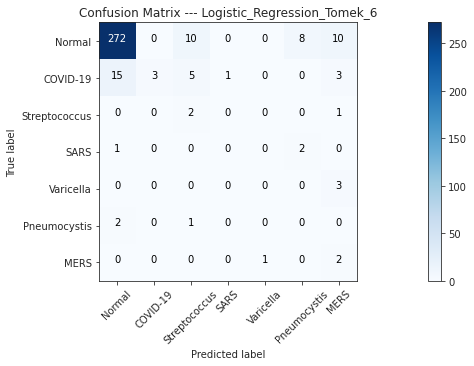

Accuracy: 0.8158
Precision (Micro): 0.8158
Precision (Macro): 0.3078
Recall (Micro): 0.8158
Recall (Macro): 0.3359
F1 (Micro): 0.8158
F1 (Macro): 0.2135


In [14]:
## Modelo Logistic Regression
logreg = LogisticRegression(solver='lbfgs')

smote_tomek(logreg, 'Logistic_Regression', X_train, X_test, y_train, y_test, classes)

-------------------------------------------------------------------- Naive_Bayes_1
----------------------------- SMOTE_Naive_Bayes_1
Confusion matrix, without normalization


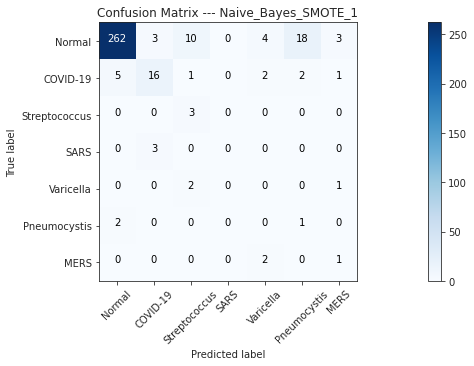

Accuracy: 0.8275
Precision (Micro): 0.8275
Precision (Macro): 0.3004
Recall (Micro): 0.8275
Recall (Macro): 0.4475
F1 (Micro): 0.8275
F1 (Macro): 0.3136
----------------------------- Tomek_Link_Naive_Bayes_1
Confusion matrix, without normalization


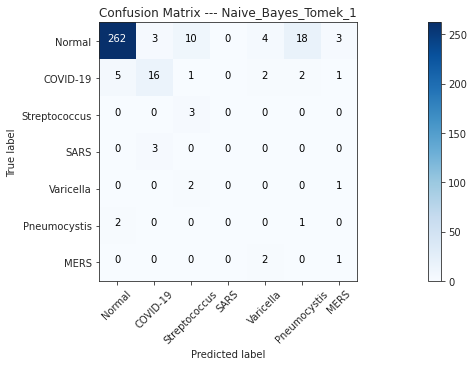

Accuracy: 0.8275
Precision (Micro): 0.8275
Precision (Macro): 0.3004
Recall (Micro): 0.8275
Recall (Macro): 0.4475
F1 (Micro): 0.8275
F1 (Macro): 0.3136
-------------------------------------------------------------------- Naive_Bayes_2
----------------------------- SMOTE_Naive_Bayes_2
Confusion matrix, without normalization


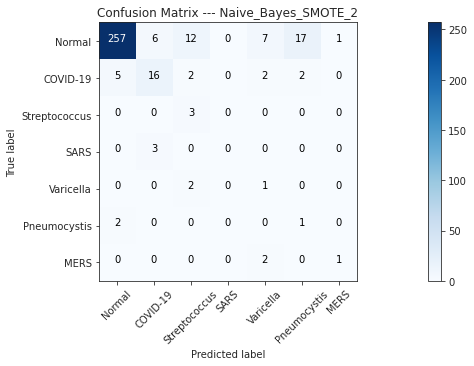

Accuracy: 0.8158
Precision (Micro): 0.8158
Precision (Macro): 0.3435
Recall (Micro): 0.8158
Recall (Macro): 0.4928
F1 (Micro): 0.8158
F1 (Macro): 0.3457
----------------------------- Tomek_Link_Naive_Bayes_2
Confusion matrix, without normalization


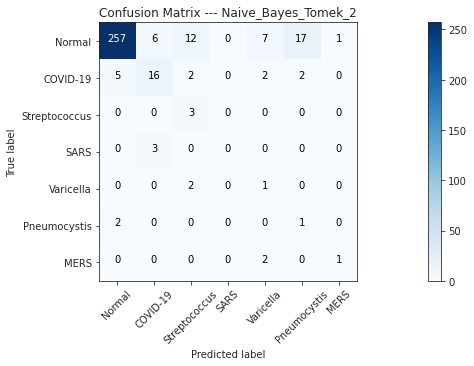

Accuracy: 0.8158
Precision (Micro): 0.8158
Precision (Macro): 0.3435
Recall (Micro): 0.8158
Recall (Macro): 0.4928
F1 (Micro): 0.8158
F1 (Macro): 0.3457
-------------------------------------------------------------------- Naive_Bayes_3
----------------------------- SMOTE_Naive_Bayes_3
Confusion matrix, without normalization


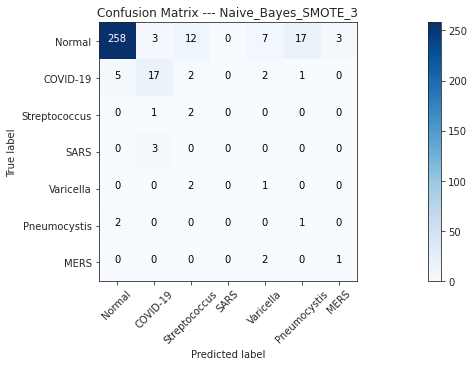

Accuracy: 0.8187
Precision (Micro): 0.8187
Precision (Macro): 0.3113
Recall (Micro): 0.8187
Recall (Macro): 0.4509
F1 (Micro): 0.8187
F1 (Macro): 0.3258
----------------------------- Tomek_Link_Naive_Bayes_3
Confusion matrix, without normalization


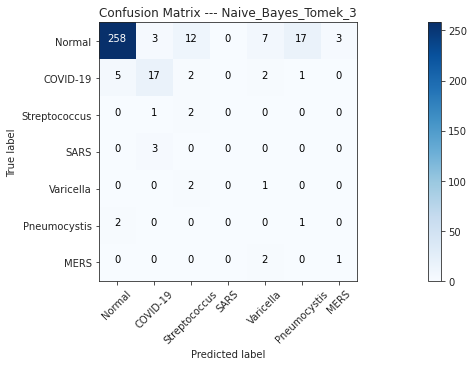

Accuracy: 0.8187
Precision (Micro): 0.8187
Precision (Macro): 0.3113
Recall (Micro): 0.8187
Recall (Macro): 0.4509
F1 (Micro): 0.8187
F1 (Macro): 0.3258
-------------------------------------------------------------------- Naive_Bayes_4
----------------------------- SMOTE_Naive_Bayes_4
Confusion matrix, without normalization


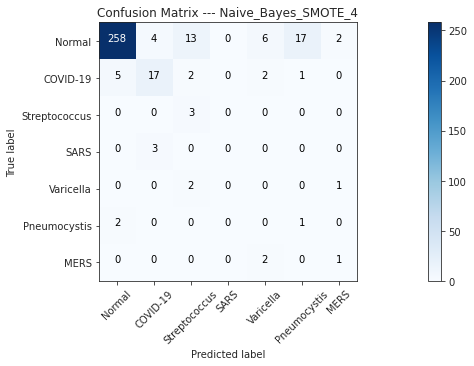

Accuracy: 0.8187
Precision (Micro): 0.8187
Precision (Macro): 0.3049
Recall (Micro): 0.8187
Recall (Macro): 0.4509
F1 (Micro): 0.8187
F1 (Macro): 0.3168
----------------------------- Tomek_Link_Naive_Bayes_4
Confusion matrix, without normalization


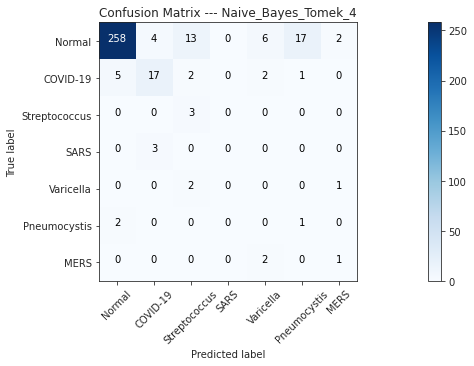

Accuracy: 0.8187
Precision (Micro): 0.8187
Precision (Macro): 0.3049
Recall (Micro): 0.8187
Recall (Macro): 0.4509
F1 (Micro): 0.8187
F1 (Macro): 0.3168
-------------------------------------------------------------------- Naive_Bayes_5
----------------------------- SMOTE_Naive_Bayes_5
Confusion matrix, without normalization


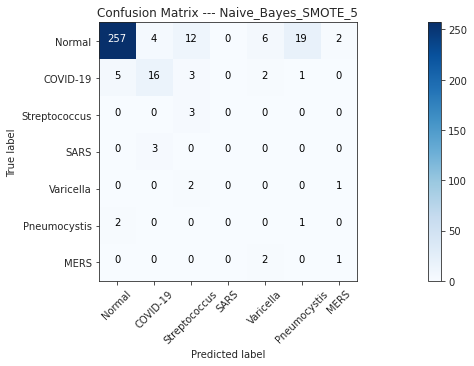

Accuracy: 0.8129
Precision (Micro): 0.8129
Precision (Macro): 0.3024
Recall (Micro): 0.8129
Recall (Macro): 0.4451
F1 (Micro): 0.8129
F1 (Macro): 0.3116
----------------------------- Tomek_Link_Naive_Bayes_5
Confusion matrix, without normalization


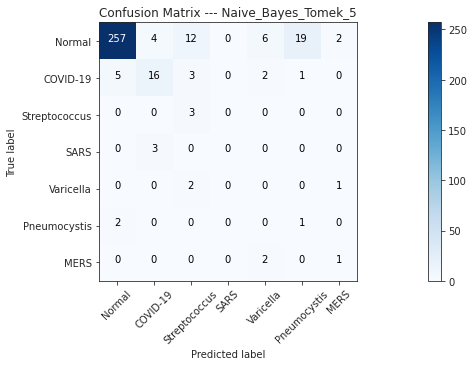

Accuracy: 0.8129
Precision (Micro): 0.8129
Precision (Macro): 0.3024
Recall (Micro): 0.8129
Recall (Macro): 0.4451
F1 (Micro): 0.8129
F1 (Macro): 0.3116
-------------------------------------------------------------------- Naive_Bayes_6
----------------------------- SMOTE_Naive_Bayes_6
Confusion matrix, without normalization


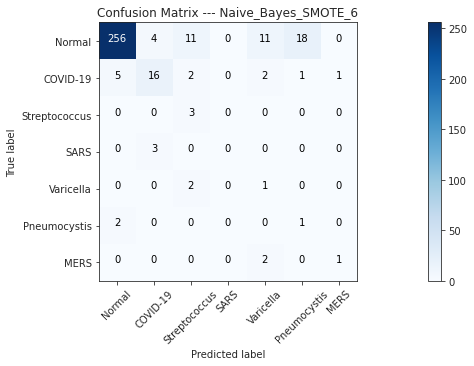

Accuracy: 0.8129
Precision (Micro): 0.8129
Precision (Macro): 0.3497
Recall (Micro): 0.8129
Recall (Macro): 0.4923
F1 (Micro): 0.8129
F1 (Macro): 0.3468
----------------------------- Tomek_Link_Naive_Bayes_6
Confusion matrix, without normalization


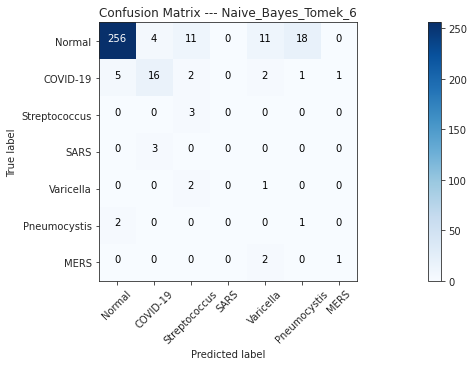

Accuracy: 0.8129
Precision (Micro): 0.8129
Precision (Macro): 0.3497
Recall (Micro): 0.8129
Recall (Macro): 0.4923
F1 (Micro): 0.8129
F1 (Macro): 0.3468


In [15]:
## Modelo Naive Bayes
naiveb = GaussianNB( )

smote_tomek(naiveb, 'Naive_Bayes', X_train, X_test, y_train, y_test, classes)

-------------------------------------------------------------------- Decision_Tree_1
----------------------------- SMOTE_Decision_Tree_1
Confusion matrix, without normalization


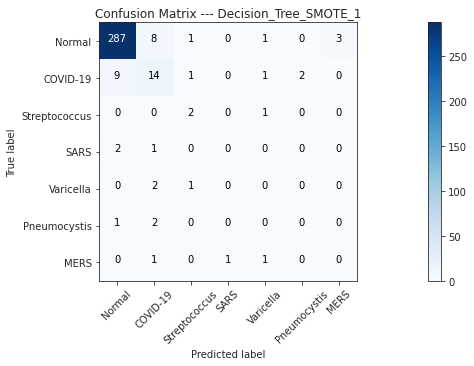

Accuracy: 0.8860
Precision (Micro): 0.8860
Precision (Macro): 0.2657
Recall (Micro): 0.8860
Recall (Macro): 0.3060
F1 (Micro): 0.8860
F1 (Macro): 0.2811
----------------------------- Tomek_Link_Decision_Tree_1
Confusion matrix, without normalization


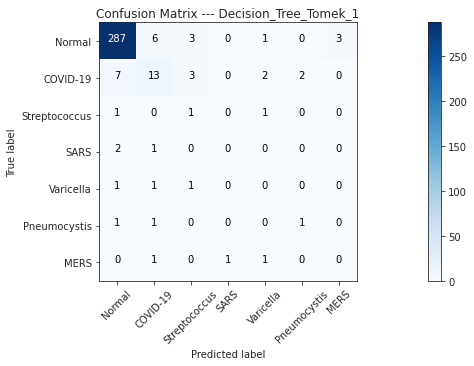

Accuracy: 0.8830
Precision (Micro): 0.8830
Precision (Macro): 0.2833
Recall (Micro): 0.8830
Recall (Macro): 0.3007
F1 (Micro): 0.8830
F1 (Macro): 0.2848
-------------------------------------------------------------------- Decision_Tree_2
----------------------------- SMOTE_Decision_Tree_2
Confusion matrix, without normalization


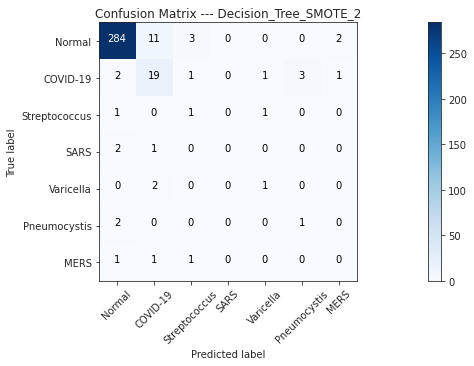

Accuracy: 0.8947
Precision (Micro): 0.8947
Precision (Macro): 0.3259
Recall (Micro): 0.8947
Recall (Macro): 0.3786
F1 (Micro): 0.8947
F1 (Macro): 0.3462
----------------------------- Tomek_Link_Decision_Tree_2
Confusion matrix, without normalization


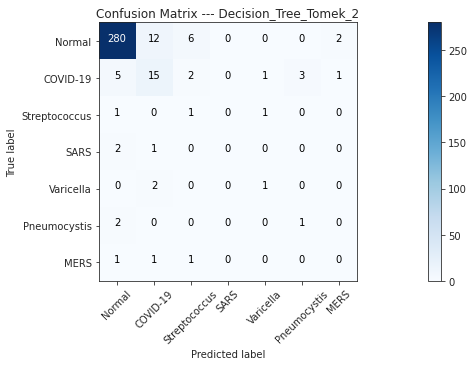

Accuracy: 0.8713
Precision (Micro): 0.8713
Precision (Macro): 0.3042
Recall (Micro): 0.8713
Recall (Macro): 0.3556
F1 (Micro): 0.8713
F1 (Macro): 0.3197
-------------------------------------------------------------------- Decision_Tree_3
----------------------------- SMOTE_Decision_Tree_3
Confusion matrix, without normalization


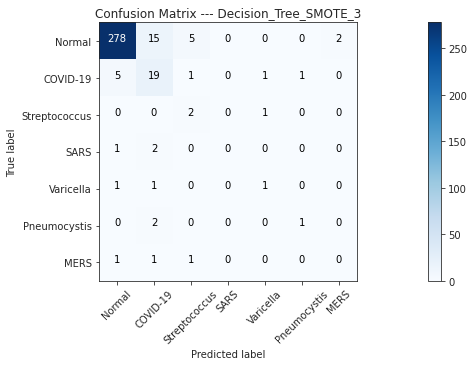

Accuracy: 0.8801
Precision (Micro): 0.8801
Precision (Macro): 0.3575
Recall (Micro): 0.8801
Recall (Macro): 0.4234
F1 (Micro): 0.8801
F1 (Macro): 0.3689
----------------------------- Tomek_Link_Decision_Tree_3
Confusion matrix, without normalization


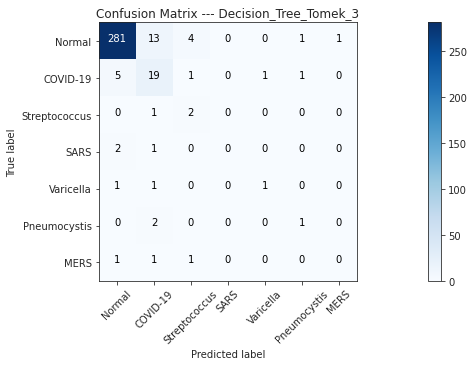

Accuracy: 0.8889
Precision (Micro): 0.8889
Precision (Macro): 0.3646
Recall (Micro): 0.8889
Recall (Macro): 0.4248
F1 (Micro): 0.8889
F1 (Macro): 0.3763
-------------------------------------------------------------------- Decision_Tree_4
----------------------------- SMOTE_Decision_Tree_4
Confusion matrix, without normalization


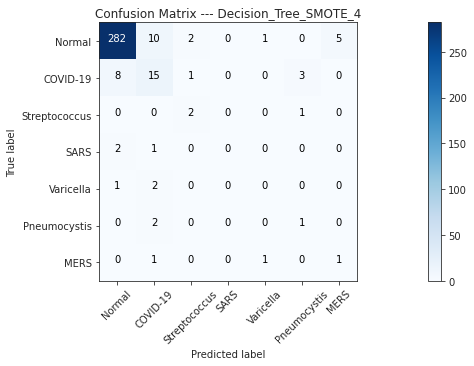

Accuracy: 0.8801
Precision (Micro): 0.8801
Precision (Macro): 0.3161
Recall (Micro): 0.8801
Recall (Macro): 0.4041
F1 (Micro): 0.8801
F1 (Macro): 0.3487
----------------------------- Tomek_Link_Decision_Tree_4
Confusion matrix, without normalization


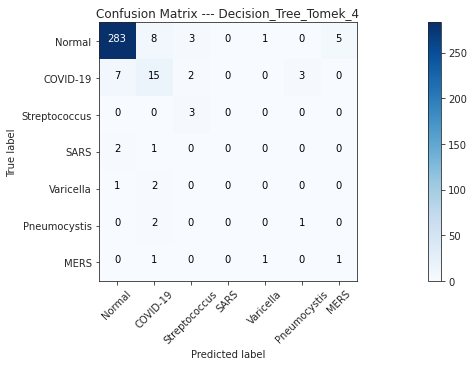

Accuracy: 0.8860
Precision (Micro): 0.8860
Precision (Macro): 0.3250
Recall (Micro): 0.8860
Recall (Macro): 0.4522
F1 (Micro): 0.8860
F1 (Macro): 0.3634
-------------------------------------------------------------------- Decision_Tree_5
----------------------------- SMOTE_Decision_Tree_5
Confusion matrix, without normalization


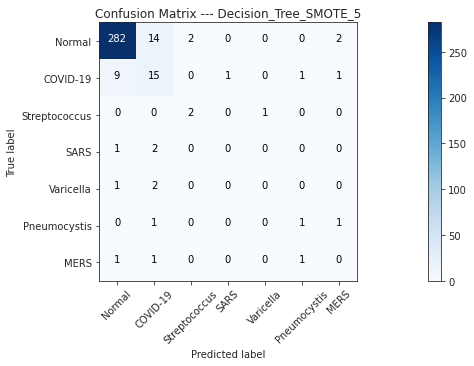

Accuracy: 0.8772
Precision (Micro): 0.8772
Precision (Macro): 0.3173
Recall (Micro): 0.8772
Recall (Macro): 0.3565
F1 (Micro): 0.8772
F1 (Macro): 0.3340
----------------------------- Tomek_Link_Decision_Tree_5
Confusion matrix, without normalization


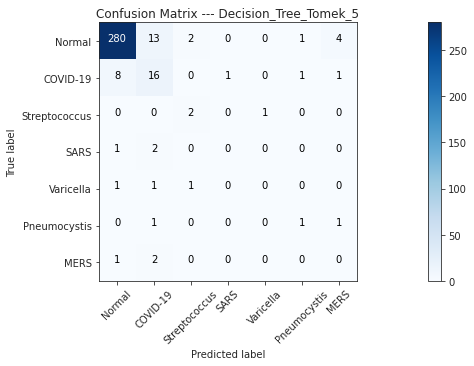

Accuracy: 0.8743
Precision (Micro): 0.8743
Precision (Macro): 0.3075
Recall (Micro): 0.8743
Recall (Macro): 0.3608
F1 (Micro): 0.8743
F1 (Macro): 0.3281
-------------------------------------------------------------------- Decision_Tree_6
----------------------------- SMOTE_Decision_Tree_6
Confusion matrix, without normalization


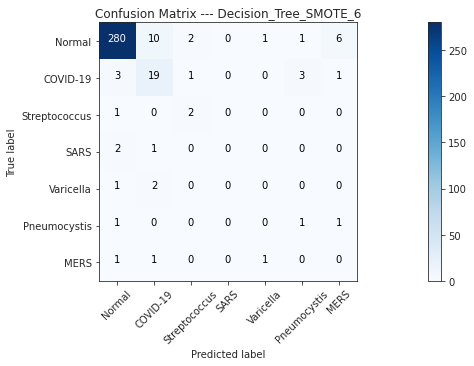

Accuracy: 0.8830
Precision (Micro): 0.8830
Precision (Macro): 0.3064
Recall (Micro): 0.8830
Recall (Macro): 0.3767
F1 (Micro): 0.8830
F1 (Macro): 0.3334
----------------------------- Tomek_Link_Decision_Tree_6
Confusion matrix, without normalization


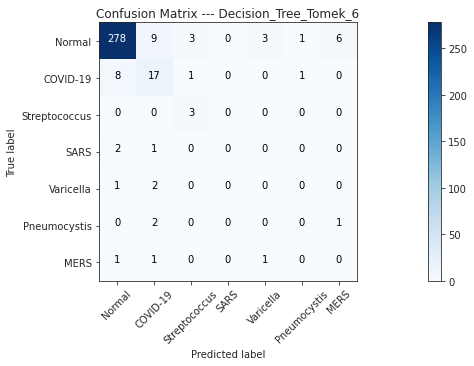

Accuracy: 0.8713
Precision (Micro): 0.8713
Precision (Macro): 0.2741
Recall (Micro): 0.8713
Recall (Macro): 0.3652
F1 (Micro): 0.8713
F1 (Macro): 0.3027


In [16]:
## Modelo Decision Tree
tree_model = tree.DecisionTreeClassifier()

smote_tomek(tree_model, 'Decision_Tree', X_train, X_test, y_train, y_test, classes)

-------------------------------------------------------------------- Random_Forest_1
----------------------------- SMOTE_Random_Forest_1
Confusion matrix, without normalization


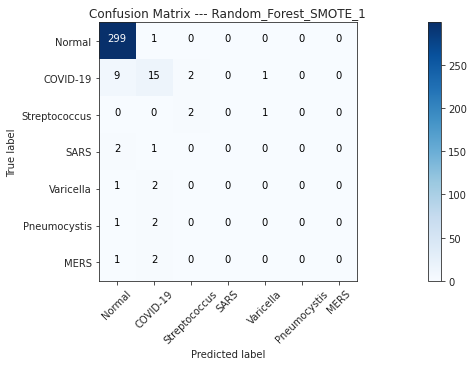

Accuracy: 0.9240
Precision (Micro): 0.9240
Precision (Macro): 0.3011
Recall (Micro): 0.9240
Recall (Macro): 0.3170
F1 (Micro): 0.9240
F1 (Macro): 0.3067
----------------------------- Tomek_Link_Random_Forest_1
Confusion matrix, without normalization


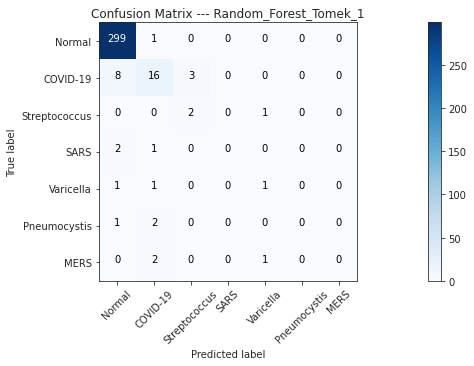

Accuracy: 0.9298
Precision (Micro): 0.9298
Precision (Macro): 0.3415
Recall (Micro): 0.9298
Recall (Macro): 0.3699
F1 (Micro): 0.9298
F1 (Macro): 0.3503
-------------------------------------------------------------------- Random_Forest_2
----------------------------- SMOTE_Random_Forest_2
Confusion matrix, without normalization


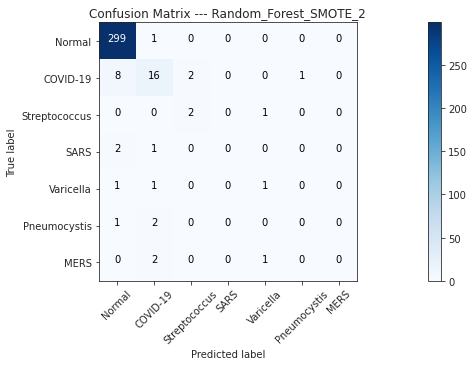

Accuracy: 0.9298
Precision (Micro): 0.9298
Precision (Macro): 0.3558
Recall (Micro): 0.9298
Recall (Macro): 0.3699
F1 (Micro): 0.9298
F1 (Macro): 0.3605
----------------------------- Tomek_Link_Random_Forest_2
Confusion matrix, without normalization


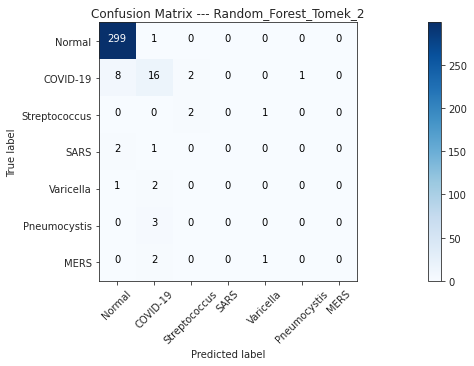

Accuracy: 0.9269
Precision (Micro): 0.9269
Precision (Macro): 0.3006
Recall (Micro): 0.9269
Recall (Macro): 0.3223
F1 (Micro): 0.9269
F1 (Macro): 0.3096
-------------------------------------------------------------------- Random_Forest_3
----------------------------- SMOTE_Random_Forest_3
Confusion matrix, without normalization


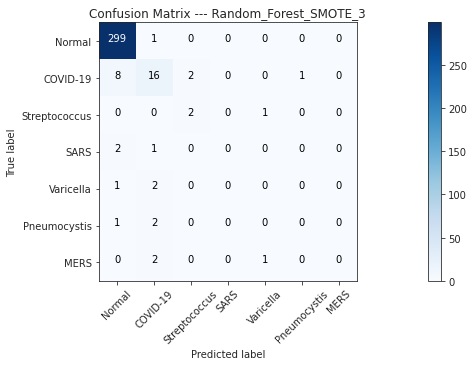

Accuracy: 0.9269
Precision (Micro): 0.9269
Precision (Macro): 0.3040
Recall (Micro): 0.9269
Recall (Macro): 0.3223
F1 (Micro): 0.9269
F1 (Macro): 0.3111
----------------------------- Tomek_Link_Random_Forest_3
Confusion matrix, without normalization


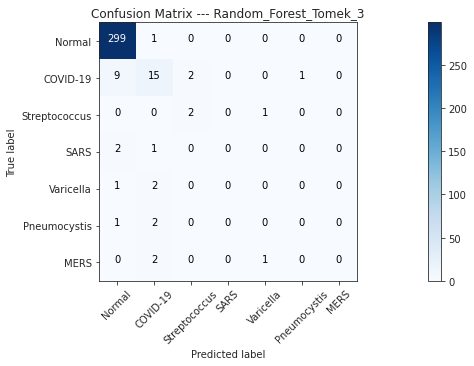

Accuracy: 0.9240
Precision (Micro): 0.9240
Precision (Macro): 0.3015
Recall (Micro): 0.9240
Recall (Macro): 0.3170
F1 (Micro): 0.9240
F1 (Macro): 0.3069
-------------------------------------------------------------------- Random_Forest_4
----------------------------- SMOTE_Random_Forest_4
Confusion matrix, without normalization


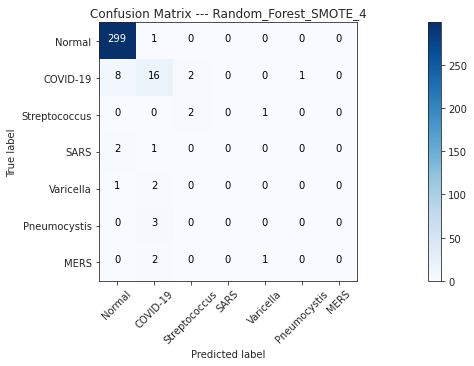

Accuracy: 0.9269
Precision (Micro): 0.9269
Precision (Macro): 0.3006
Recall (Micro): 0.9269
Recall (Macro): 0.3223
F1 (Micro): 0.9269
F1 (Macro): 0.3096
----------------------------- Tomek_Link_Random_Forest_4
Confusion matrix, without normalization


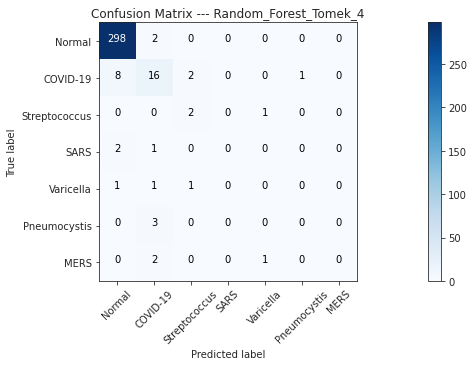

Accuracy: 0.9240
Precision (Micro): 0.9240
Precision (Macro): 0.2863
Recall (Micro): 0.9240
Recall (Macro): 0.3218
F1 (Micro): 0.9240
F1 (Macro): 0.2991
-------------------------------------------------------------------- Random_Forest_5
----------------------------- SMOTE_Random_Forest_5
Confusion matrix, without normalization


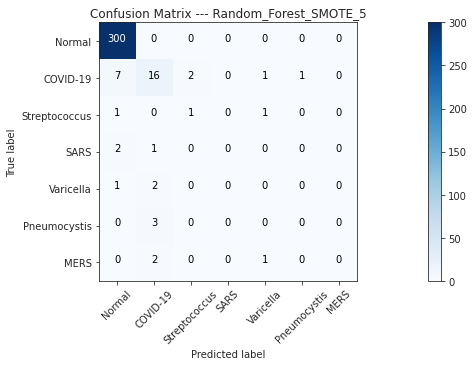

Accuracy: 0.9269
Precision (Micro): 0.9269
Precision (Macro): 0.2807
Recall (Micro): 0.9269
Recall (Macro): 0.2751
F1 (Micro): 0.9269
F1 (Macro): 0.2775
----------------------------- Tomek_Link_Random_Forest_5
Confusion matrix, without normalization


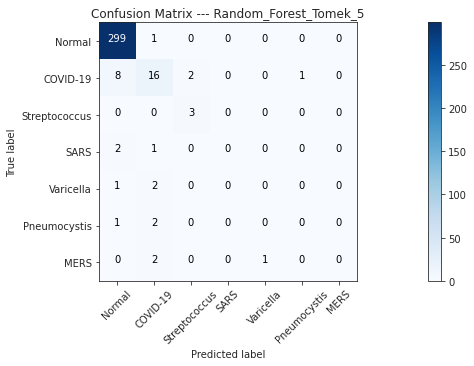

Accuracy: 0.9298
Precision (Micro): 0.9298
Precision (Macro): 0.3183
Recall (Micro): 0.9298
Recall (Macro): 0.3699
F1 (Micro): 0.9298
F1 (Macro): 0.3366
-------------------------------------------------------------------- Random_Forest_6
----------------------------- SMOTE_Random_Forest_6
Confusion matrix, without normalization


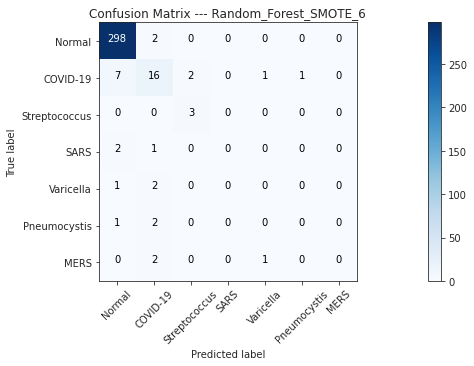

Accuracy: 0.9269
Precision (Micro): 0.9269
Precision (Macro): 0.3149
Recall (Micro): 0.9269
Recall (Macro): 0.3694
F1 (Micro): 0.9269
F1 (Macro): 0.3349
----------------------------- Tomek_Link_Random_Forest_6
Confusion matrix, without normalization


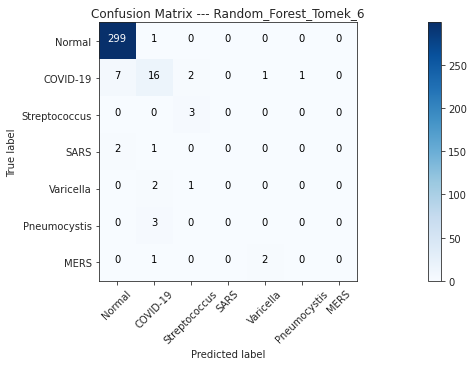

Accuracy: 0.9298
Precision (Micro): 0.9298
Precision (Macro): 0.3053
Recall (Micro): 0.9298
Recall (Macro): 0.3699
F1 (Micro): 0.9298
F1 (Macro): 0.3254


In [17]:
## Modelo Random Forest
random_forest = RandomForestClassifier(criterion='entropy', class_weight='balanced')

smote_tomek(random_forest, 'Random_Forest', X_train, X_test, y_train, y_test, classes)

## Testing models in real pictures

In [18]:
model_types = ['KNN', 'SVM', 'Logistic_Regression', 'Naive_Bayes', 'Decision_Tree', 'Random_Forest']

k = list(range(1,len(classes)))

for model in model_types:
  for i in ['_SMOTE', '_Tomek']:
    for time in k:
      model_teste(f'{model}{i}_{time}_model')

-------------------------------------------------------------------- KNN_SMOTE_1_model
Classe da imagem teste - Pneumonia/Acellular/Viral/Coronavirus/COVID-19
Classe da imagem teste - Pneumonia/Acellular/Viral/Coronavirus/COVID-19
Classe da imagem teste - Pneumonia/Acellular/Viral/Coronavirus/COVID-19
Classe da imagem teste - Pneumonia/Acellular/Viral/Coronavirus/COVID-19
-------------------------------------------------------------------- KNN_SMOTE_2_model
Classe da imagem teste - Pneumonia/Acellular/Viral/Coronavirus/COVID-19
Classe da imagem teste - Pneumonia/Acellular/Viral/Coronavirus/COVID-19
Classe da imagem teste - Pneumonia/Acellular/Viral/Coronavirus/COVID-19
Classe da imagem teste - Pneumonia/Acellular/Viral/Coronavirus/COVID-19
-------------------------------------------------------------------- KNN_SMOTE_3_model
Classe da imagem teste - Pneumonia/Acellular/Viral/Coronavirus/COVID-19
Classe da imagem teste - Pneumonia/Acellular/Viral/Coronavirus/COVID-19
Classe da imagem te